# Setup

**Imports**

In [2]:
import datetime as dt
from math import log
import IPython
import geopandas
import contextily as cx
from math import asin, cos, radians, sin, sqrt


from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
from scipy.signal import spectrogram

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [5]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

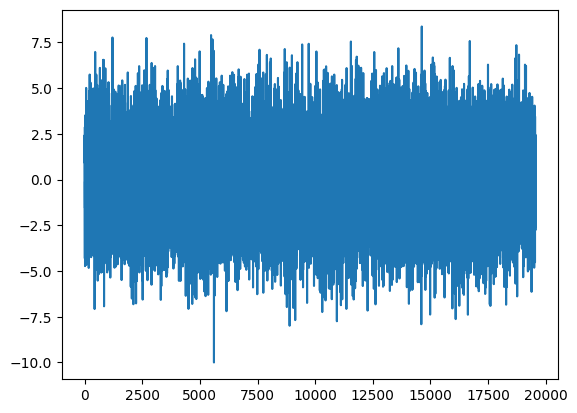

In [6]:
plt.plot(X_train[0])

In [5]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


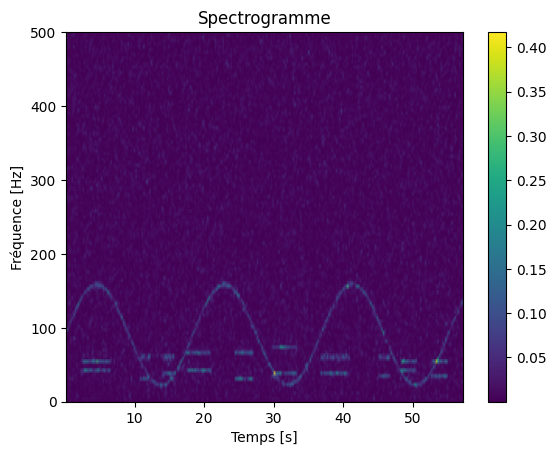

In [ ]:
fs = 22050  # fréquence d'échantillonnage


f, tt, Sxx = spectrogram(X_train[6], fs)

plt.pcolormesh(tt, f, Sxx, shading='gouraud')
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.title('Spectrogramme')
plt.colorbar()
plt.show()

# Question 2

In [5]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 3

# Question 4

## Utility functions: 

In [6]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    return graph.is_connected()

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [7]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [8]:
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


# Question 5

# Question 6

# Question 7